## Autoencoder feature analysis
In this notebook we extract features from the original dataset and analyse the feature distributions. <br>
Samples are represented as an array of tipe:<br>
$x_0,\,y_0,\,z_0,\,x_1,\,y_1,\,z_1,\,...,\,x_n,\,y_n\,z_n,\, 0,\,0\,...\,0$ <br>
Where n is the number of hits in the track, and zero-padding is applied to match the same array dimension for every track in the dataset.

In [61]:
import yaml
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from quake.models.qsvm.qsvm_tester import get_features

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA, TruncatedSVD


In [4]:
# Loading the dataset
data_folder = Path('../../output_5/data')
train_folder = Path('../../output_5/models/autoencoder')
setup = load_runcard("../../output_5/cards/runcard.yaml")
train_generator, val_generator, test_generator = read_data(
    data_folder, train_folder, setup, split_from_maps=True
)

msetup = setup["model"]["autoencoder"]
max_input_nb = np.max([train_generator.fixed_length_inputs.shape[1],
                        val_generator.fixed_length_inputs.shape[1],
                        test_generator.fixed_length_inputs.shape[1]])
print(f"Arrays are padded to match dimension {max_input_nb}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_5/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125282 training points, of which 50.10% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26846 training points, of which 50.02% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26847 training points, of which 49.69% positives


Arrays are padded to match dimension 64


In [5]:
# Loading runcard and model options
setup = load_runcard("../../output_5/cards/runcard.yaml")
msetup = setup["model"]["autoencoder"]

msetup.update({"ckpt": train_folder.parent / f"autoencoder/autoencoder.h5"})

# Loading the network
network = load_and_compile_network(msetup, setup["run_tf_eagerly"], max_input_nb)

[INFO] (quake.autoencoder) Loading weights at ../../output_5/models/autoencoder/autoencoder.h5


In [6]:
network.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc0 (LBAD)                 multiple                  13000     
                                                                 
 Enc1 (LBAD)                 multiple                  120600    
                                                                 
 Enc2 (LBAD)                 multiple                  150250    
                                                                 
 Enc3 (LBAD)                 multiple                  25100     
                                                                 
 Enc4 (LBAD)                 multiple                  606       
                                                                 
 Dec0 (LBAD)                 multiple                  700       
                                                                 
 Dec1 (LBAD)                 multiple                  

In [10]:
# Computing autoencoder predictions
validation_preds = network.predict(val_generator)

# Computing autoencoder performance (MSE metric)
network.evaluate(val_generator)

537/537 [==============================] - 1s 3ms/step - loss: 0.0349 - MSE: 0.0349


[0.03487572446465492, 0.03487572446465492]

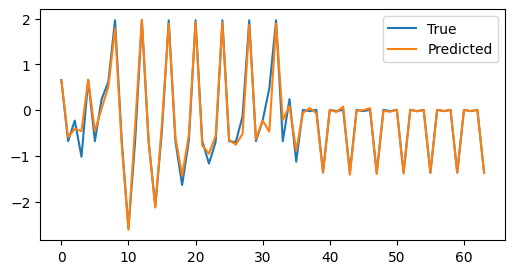

In [14]:
# Displaying the true value vs the autoencoder prediction
track_id = 0
plt.figure(figsize=(6,3))
plt.plot(val_generator.inputs[track_id])
plt.plot(validation_preds[track_id]) 
plt.legend(["True", "Predicted"])

In [22]:
# Loading features from the autoencoder latent space
# dataset and labels are lists. To get training, validation and test data, call entry 0, 1 and 2 respectively
dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
latent_dim = dataset[0].shape[1]

print(f"Latent space dimension: {latent_dim}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_5/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125282 training points, of which 50.10% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26846 training points, of which 50.02% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26847 training points, of which 49.69% positives
[INFO] (quake.autoencoder) Loading weights at ../../output_5/models/autoencoder/autoencoder.h5


537/537 [==============================] - 1s 2ms/step
Latent space dimension: 6


In [23]:
# Rescaling features from 0 to 1
scaler = MinMaxScaler((0, 1))
dataset_train = scaler.fit_transform(dataset[0])

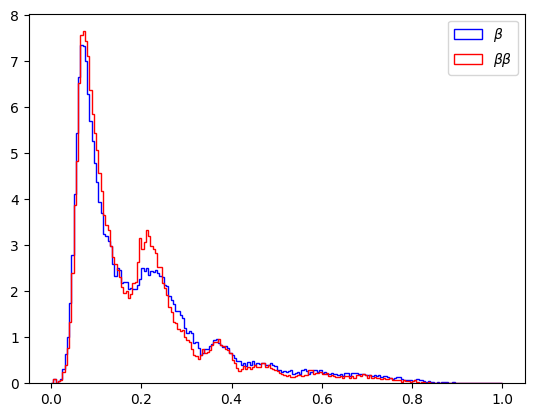

In [83]:
# Plotting feature distributions within classes
feature_nb = 0
plt.hist(dataset_train[labels[0] == 0, feature_nb], range = [0,1], bins = 200, histtype="step", density = True, color = "blue")[-1]
plt.hist(dataset_train[labels[0] == 1, feature_nb], range = [0,1], bins = 200, histtype="step", density = True, color = "red")[-1]
plt.legend([r"$\beta$", r"$\beta\beta$"])


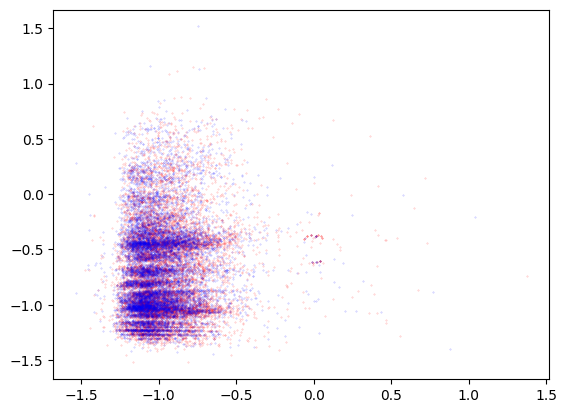

In [86]:
# 2D scatterplots
ft_1_idx = 3
ft_2_idx = 4 
plt.scatter(x = dataset[0][labels[0] == 0, ft_1_idx][:10000], y = dataset[0][labels[0] == 0, ft_2_idx][:10000], s = 0.1, alpha = 0.3, c = "r")
plt.scatter(x = dataset[0][labels[0] == 1, ft_1_idx][:10000], y = dataset[0][labels[0] == 1, ft_2_idx][:10000], s = 0.1, alpha = 0.3, c = "b")

In [39]:
# Doing univariate analysis
label_relation = mutual_info_classif(dataset_train, labels[0])
print(label_relation)

[0.0052426  0.00436498 0.00360646 0.00152654 0.00331089 0.03340082]


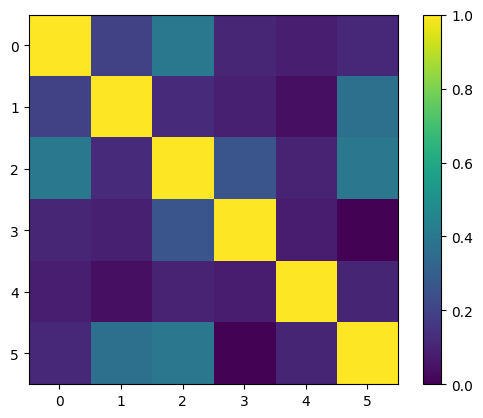

In [43]:
# Plotting linear correlations between features
corrmat = np.abs(np.corrcoef(dataset[0].T))
plt.imshow(corrmat, clim = [0.0,1])
plt.colorbar()

In [40]:
# Preparing a subset for training an SVM
ds_train = scaler.transform(dataset[0])[:10000] # dataset is already shuffled
ds_val = scaler.transform(dataset[1])[:10000]
ds_test = scaler.transform(dataset[2])[:10000]

In [71]:
# Training a gaussian SVM and optimizing hyperparameters
# With the settings below, it may take a few minutes to run.
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],        # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]  # Kernel coefficient for 'rbf' kernel
}

gaussian = SVC(kernel = "rbf")

grid_search = GridSearchCV(gaussian, param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(ds_train, labels[0][:10000])


best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
best_model = grid_search.best_estimator_

gaussian_clf = SVC(kernel = "rbf", C = best_C, gamma = best_gamma).fit(ds_train, labels[0][:10000])
accuracy = gaussian_clf.score(ds_val, labels[1][:10000])

print("Best model is", best_model,"with accuracy", accuracy)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best model is SVC(C=1000, gamma=0.1) with accuracy 0.6133


In [64]:
# Doing PCA analysis
pca = PCA(n_components=latent_dim)
pca.fit(dataset_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.34817433 0.27866592 0.20993605 0.08735769 0.051003   0.024863  ]
[57.448044 51.394756 44.608784 28.775803 21.987444 15.351601]


Text(0, 0.5, 'Total explained variance')

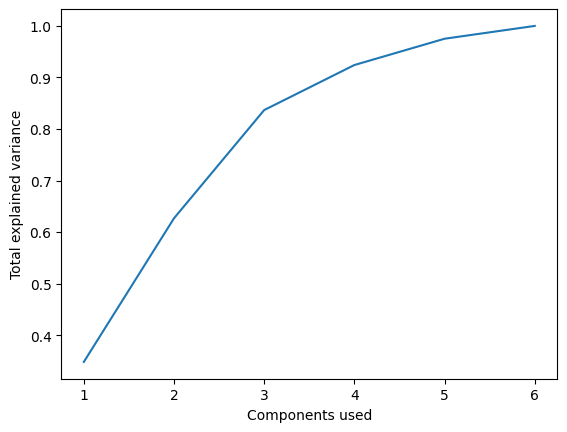

In [68]:
plt.plot(np.arange(1, latent_dim+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components used")
plt.ylabel("Total explained variance")

In [96]:
# keeping only some components
nb_features_to_keep = 3
ds_train_transformed = pca.transform(ds_train)[:, :nb_features_to_keep]
ds_val_transformed = pca.transform(ds_val)[:, :nb_features_to_keep]

In [97]:
gaus = SVC(kernel = "rbf", C = 1000, gamma = 0.1)
gaus.fit(ds_train_transformed, labels[0][:10000])
gaus.score(ds_val_transformed, labels[1][:10000])

0.611